In [20]:
# Импортируем всё необходимое
import json
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay
)  
from sklearn.inspection import permutation_importance
from joblib import dump

import matplotlib.pyplot as plt

In [21]:
# Константы 
RANDOM_STATE = 42

BASE_DIR = Path("homeworks/HW06")
ARTIFACTS_DIR = BASE_DIR / "artifacts"
FIGURES_DIR = ARTIFACTS_DIR / "figures"

FIGURES_DIR.mkdir(parents=True, exist_ok=True)

In [22]:
BASE_DIR = Path(".")
DATA_PATH = Path("../../project/data/S06-hw-dataset-02.csv")

ARTIFACTS_DIR = BASE_DIR / "artifacts"
FIGURES_DIR = ARTIFACTS_DIR / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

DATA_PATH

WindowsPath('../../project/data/S06-hw-dataset-02.csv')

In [23]:
df = pd.read_csv(DATA_PATH)

display(df.head(3))
df.info()

display(df.describe(include="all").T.head(10))

print("Missing values:", int(df.isna().sum().sum()))
display(df["target"].value_counts())
display(df["target"].value_counts(normalize=True))

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
0,1,-0.149235,-2.826966,-0.522901,-4.198449,1.364943,0.815043,-1.195518,-1.932232,2.396353,...,-0.159323,0.448015,0.572745,0.149916,0.878392,-0.679733,1.412751,0.421883,9.217167,1
1,2,-1.966180,-4.877542,0.268367,-9.607791,0.097149,1.347185,-3.872575,-0.395117,1.710068,...,-0.389212,1.383794,0.169876,0.043969,-0.963545,1.006643,-2.488690,9.590124,24.772826,0
2,3,-0.555964,-0.999920,0.209673,-14.119498,-1.808950,-0.006222,-4.651108,0.911944,-0.289037,...,-1.383970,3.044321,-0.182864,1.425649,-8.418598,-4.629754,-0.439798,0.555919,41.800517,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 39 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       18000 non-null  int64  
 1   f01      18000 non-null  float64
 2   f02      18000 non-null  float64
 3   f03      18000 non-null  float64
 4   f04      18000 non-null  float64
 5   f05      18000 non-null  float64
 6   f06      18000 non-null  float64
 7   f07      18000 non-null  float64
 8   f08      18000 non-null  float64
 9   f09      18000 non-null  float64
 10  f10      18000 non-null  float64
 11  f11      18000 non-null  float64
 12  f12      18000 non-null  float64
 13  f13      18000 non-null  float64
 14  f14      18000 non-null  float64
 15  f15      18000 non-null  float64
 16  f16      18000 non-null  float64
 17  f17      18000 non-null  float64
 18  f18      18000 non-null  float64
 19  f19      18000 non-null  float64
 20  f20      18000 non-null  float64
 21  f21      180

,count,mean,std,min,25%,50%,75%,max
id,18000.0,9000.500000,5196.296758,1.000000,4500.750000,9000.500000,13500.250000,18000.000000
f01,18000.0,-0.418555,2.178005,-10.014698,-1.866134,-0.465100,0.966393,9.589975
f02,18000.0,0.614251,3.926778,-15.510323,-2.048192,0.600291,3.229850,15.417329
f03,18000.0,0.004559,1.000134,-4.031762,-0.673127,0.003581,0.671390,3.817025
f04,18000.0,0.059000,5.713672,-23.663256,-3.544964,0.072826,3.689490,26.815691
f05,18000.0,0.405086,2.497581,-12.289308,-1.153000,0.485625,2.075739,10.665184
f06,18000.0,0.012123,0.987226,-3.741536,-0.653090,0.018765,0.689304,3.528280
f07,18000.0,-0.283473,2.193891,-9.591425,-1.743214,-0.251263,1.195481,7.794627
f08,18000.0,-0.266880,2.081431,-8.293319,-1.688121,-0.302463,1.109589,8.892834
f09,18000.0,0.255107,2.225776,-13.655742,-1.177480,0.350739,1.764113,8.699629


Missing values: 0


target
0    13273
1     4727
Name: count, dtype: int64

target
0    0.737389
1    0.262611
Name: proportion, dtype: float64

In [24]:
y = df["target"]
X = df.drop(columns=["target"])

if "id" in X.columns:
    X = X.drop(columns=["id"])

X.shape, y.shape

((18000, 37), (18000,))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

X_train.shape, X_test.shape

((14400, 37), (3600, 37))

In [26]:
def evaluate_binary(model, X, y):
    y_pred = model.predict(X)
    out = {
        "accuracy": float(accuracy_score(y, y_pred)),
        "f1": float(f1_score(y, y_pred)),
        "roc_auc": None
    }
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X)[:, 1]
        out["roc_auc"] = float(roc_auc_score(y, y_prob))
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X)
        out["roc_auc"] = float(roc_auc_score(y, y_score))
    return out

In [27]:
results = {}
search_summaries = {}

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
results["DummyClassifier"] = evaluate_binary(dummy, X_test, y_test)

logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=3000, random_state=RANDOM_STATE))
])
logreg.fit(X_train, y_train)
results["LogisticRegression"] = evaluate_binary(logreg, X_test, y_test)

pd.DataFrame(results).T

,accuracy,f1,roc_auc
DummyClassifier,0.737500,0.000000,0.500000
LogisticRegression,0.811944,0.560675,0.797691


In [28]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [29]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

tree_grid = {
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_leaf": [1, 5, 10, 20],
    "ccp_alpha": [0.0, 1e-4, 1e-3]
}

tree_search = GridSearchCV(
    tree,
    tree_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1
)
tree_search.fit(X_train, y_train)

best_tree = tree_search.best_estimator_
results["DecisionTree"] = evaluate_binary(best_tree, X_test, y_test)

search_summaries["DecisionTree"] = {
    "scoring": "f1",
    "best_params": tree_search.best_params_,
    "best_cv_score": float(tree_search.best_score_)
}

pd.DataFrame(results).T

,accuracy,f1,roc_auc
DummyClassifier,0.737500,0.000000,0.500000
LogisticRegression,0.811944,0.560675,0.797691
DecisionTree,0.838333,0.657647,0.839790


In [30]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(
    n_estimators=100,        # комп виснет, поменьше бахнем
    random_state=RANDOM_STATE,
    n_jobs=4
)

rf_dist = {
    "max_depth": [None, 6, 10, 14, 20],
    "min_samples_leaf": [1, 2, 5, 10, 20],
    "max_features": ["sqrt", 0.3, 0.5, None]
}

rf_search = RandomizedSearchCV(
    rf,
    rf_dist,
    n_iter=5,               # чтоб комп не взорвался еще раз
    scoring="f1",
    cv=cv,                   
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_
results["RandomForest"] = evaluate_binary(best_rf, X_test, y_test)

search_summaries["RandomForest"] = {
    "search_type": "RandomizedSearchCV",
    "scoring": "f1",
    "cv_splits": cv.get_n_splits(),
    "n_iter": 16,
    "best_params": rf_search.best_params_,
    "best_cv_score": float(rf_search.best_score_)
}

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [31]:
hgb = HistGradientBoostingClassifier(random_state=RANDOM_STATE)

hgb_grid = {
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5, 7],
    "max_leaf_nodes": [15, 31]
}

hgb_search = GridSearchCV(
    hgb,
    hgb_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1
)
hgb_search.fit(X_train, y_train)

best_hgb = hgb_search.best_estimator_
results["HistGradientBoosting"] = evaluate_binary(best_hgb, X_test, y_test)

search_summaries["HistGradientBoosting"] = {
    "scoring": "f1",
    "best_params": hgb_search.best_params_,
    "best_cv_score": float(hgb_search.best_score_)
}

results_df = pd.DataFrame(results).T.sort_values(by=["roc_auc", "f1"], ascending=False)
results_df

,accuracy,f1,roc_auc
HistGradientBoosting,0.903333,0.798378,0.928401
RandomForest,0.889722,0.758956,0.923538
DecisionTree,0.838333,0.657647,0.839790
LogisticRegression,0.811944,0.560675,0.797691
DummyClassifier,0.737500,0.000000,0.500000


In [32]:
def pick_best(results_df):
    df2 = results_df.copy()
    # roc_auc может быть None -> заменим на -inf
    df2["roc_auc_filled"] = df2["roc_auc"].fillna(-np.inf)
    df2 = df2.sort_values(by=["roc_auc_filled", "f1", "accuracy"], ascending=False)
    return df2.index[0]

best_name = pick_best(results_df)
best_name

'HistGradientBoosting'

In [33]:
best_model_map = {
    "DummyClassifier": dummy,
    "LogisticRegression": logreg,
    "DecisionTree": best_tree,
    "RandomForest": best_rf,
    "HistGradientBoosting": best_hgb
}
best_model = best_model_map[best_name]
best_model

,"loss loss: {'log_loss'}, default='log_loss'The loss function to use in the boosting process.For binary classification problems, 'log_loss' is also known as logistic loss,binomial deviance or binary crossentropy. Internally, the model fits one treeper boosting iteration and uses the logistic sigmoid function (expit) asinverse link function to compute the predicted positive class probability.For multiclass classification problems, 'log_loss' is also known as multinomialdeviance or categorical crossentropy. Internally, the model fits one tree perboosting iteration and per class and uses the softmax function as inverse linkfunction to compute the predicted probabilities of the classes.",'log_loss'
,"learning_rate learning_rate: float, default=0.1The learning rate, also known as *shrinkage*. This is used as amultiplicative factor for the leaves values. Use ``1`` for noshrinkage.",0.1
,"max_iter max_iter: int, default=100The maximum number of iterations of the boosting process, i.e. themaximum number of trees for binary classification. For multiclassclassification, `n_classes` trees per iteration are built.",100
,"max_leaf_nodes max_leaf_nodes: int or None, default=31The maximum number of leaves for each tree. Must be strictly greaterthan 1. If None, there is no maximum limit.",31
,"max_depth max_depth: int or None, default=NoneThe maximum depth of each tree. The depth of a tree is the number ofedges to go from the root to the deepest leaf.Depth isn't constrained by default.",7
,"min_samples_leaf min_samples_leaf: int, default=20The minimum number of samples per leaf. For small datasets with lessthan a few hundred samples, it is recommended to lower this valuesince only very shallow trees would be built.",20
,"l2_regularization l2_regularization: float, default=0The L2 regularization parameter penalizing leaves with small hessians.Use ``0`` for no regularization (default).",0.0
,"max_features max_features: float, default=1.0Proportion of randomly chosen features in each and every node split.This is a form of regularization, smaller values make the trees weakerlearners and might prevent overfitting.If interaction constraints from `interaction_cst` are present, only allowedfeatures are taken into account for the subsampling... versionadded:: 1.4",1.0
,"max_bins max_bins: int, default=255The maximum number of bins to use for non-missing values. Beforetraining, each feature of the input array `X` is binned intointeger-valued bins, which allows for a much faster training stage.Features with a small number of unique values may use less than``max_bins`` bins. In addition to the ``max_bins`` bins, one more binis always reserved for missing values. Must be no larger than 255.",255
,"categorical_features categorical_features: array-like of {bool, int, str} of shape (n_features) or shape (n_categorical_features,), default='from_dtype'Indicates the categorical features.- None : no feature will be considered categorical.- boolean array-like : boolean mask indicating categorical features.- integer array-like : integer indices indicating categorical features.- str array-like: names of categorical features (assuming the training data has feature names).- `""from_dtype""`: dataframe columns with dtype ""category"" are considered to be categorical features. The input must be an object exposing a ``__dataframe__`` method such as pandas or polars DataFrames to use this feature.For each categorical feature, there must be at most `max_bins` uniquecategories. Negative values for categorical features encoded as numericdtypes are treated as missing values. All categorical values areconverted to floating point numbers. This means that categorical valuesof 1.0 and 1 are treated as the same category.Read more in the :ref:`User Guide `... versionadded:: 0.24.. versionchanged:: 1.2 Added support for feature names... versionchanged:: 1.4 Added `""from_dtype""` option... versionchanged:: 1.6 The default value changed from `None` to `""from_dtype""`.",'from_dtype

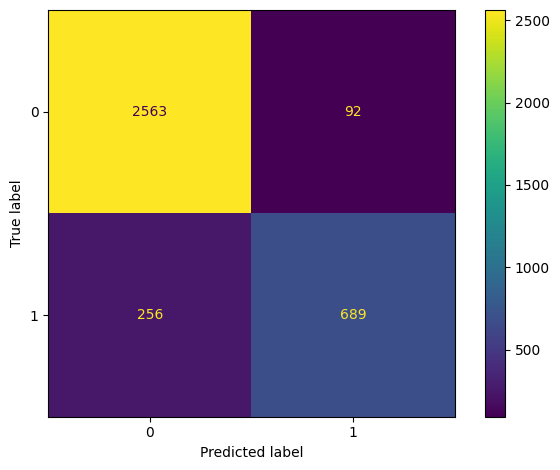

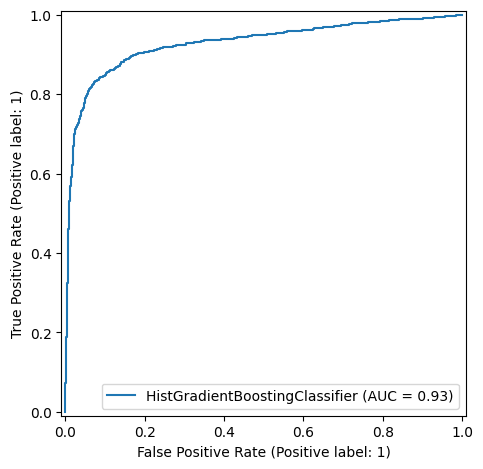

In [34]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "confusion_matrix.png", dpi=150)
plt.show()

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "roc_curve.png", dpi=150)
plt.show()

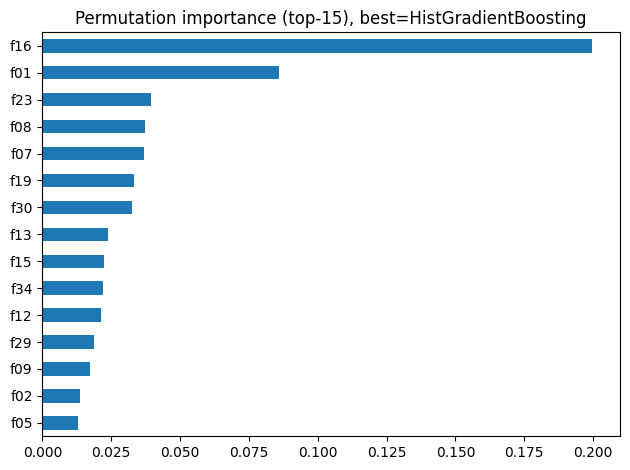

f16    0.199768
f01    0.085730
f23    0.039529
f08    0.037169
f07    0.036809
f19    0.033142
f30    0.032562
f13    0.023954
f15    0.022365
f34    0.022144
f12    0.021125
f29    0.018815
f09    0.017152
f02    0.013802
f05    0.013019
dtype: float64

In [35]:
perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    scoring="f1",
    n_repeats=10,
    random_state=RANDOM_STATE
)

imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
topk = imp.head(15)

plt.figure()
topk[::-1].plot(kind="barh")
plt.title(f"Permutation importance (top-15), best={best_name}")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "permutation_importance.png", dpi=150)
plt.show()

topk

In [36]:
with open(ARTIFACTS_DIR / "metrics_test.json", "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

# search_summaries.json
with open(ARTIFACTS_DIR / "search_summaries.json", "w", encoding="utf-8") as f:
    json.dump(search_summaries, f, indent=2, ensure_ascii=False)

# best_model.joblib
dump(best_model, ARTIFACTS_DIR / "best_model.joblib")

# best_model_meta.json
best_model_meta = {
    "best_model_name": best_name,
    "selection_rule": "roc_auc (if available) else f1",
    "dataset": "S06-hw-dataset-02.csv",
    "random_state": RANDOM_STATE,
    "test_size": 0.2,
    "test_metrics": results[best_name],
    "best_params": search_summaries.get(best_name, {}).get("best_params", None)
}
with open(ARTIFACTS_DIR / "best_model_meta.json", "w", encoding="utf-8") as f:
    json.dump(best_model_meta, f, indent=2, ensure_ascii=False)

best_model_meta

{'best_model_name': 'HistGradientBoosting',
 'selection_rule': 'roc_auc (if available) else f1',
 'dataset': 'S06-hw-dataset-02.csv',
 'random_state': 42,
 'test_size': 0.2,
 'test_metrics': {'accuracy': 0.9033333333333333,
  'f1': 0.7983777520278099,
  'roc_auc': 0.9284014388345838},
 'best_params': {'learning_rate': 0.1, 'max_depth': 7, 'max_leaf_nodes': 31}}